# Data Processing for Duckweed Detection

## Load the base dataset and libraries

In [ ]:
import glob
import pandas as pd
from tqdm.notebook import tqdm
from xml.etree import ElementTree
import cv2 as cv2
import matplotlib.pyplot as plt
import os
import shutil
from pathlib import Path
import numpy as np
from xml.etree.ElementTree import parse, Element, SubElement
import random
from PIL import Image, ImageOps
import operator

In [ ]:
BASE_DATASET_PATH = "base_dataset/"

if os.path.exists(BASE_DATASET_PATH):
  shutil.rmtree(BASE_DATASET_PATH)
os.mkdir(BASE_DATASET_PATH)

partitions = {
  "mauricio":{"id":"JkwcBVjWBe", "key":"MMojgudzPt"}, 
  "yamil":{"id":"lRuqfFNfQ5", "key":"BzG7vNQxKW"}
}

for key, partition in partitions.items():
  download_path = "https://app.roboflow.com/ds/%s?key=%s"%(partition["id"], partition["key"])
  target_path = BASE_DATASET_PATH+key
  !curl -L "$download_path" > roboflow.zip; unzip roboflow.zip -d "$target_path" > /dev/null; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   883  100   883    0     0    742      0  0:00:01  0:00:01 --:--:--   744
100  852M  100  852M    0     0  4844k      0  0:03:00  0:03:00 --:--:-- 4984k 3457k      0  0:04:12  0:00:07  0:04:05 4960k0  4667k      0  0:03:07  0:00:43  0:02:24 4978k:03:01  0:01:32  0:01:29 4981kM    0     0  4840k      0  0:03:00  0:01:48  0:01:12 5109k   0  4860k      0  0:02:59  0:02:04  0:00:55 4988k0     0  4862k      0  0:02:59  0:02:07  0:00:52 4998k 0     0  4818k      0  0:03:01  0:02:32  0:00:29 5007k   0     0  4839k      0  0:03:00  0:02:51  0:00:09 4982kM    0     0  4842k      0  0:03:00  0:02:56  0:00:04 4969k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1874      0 --:--:-- --:--:-- --:

## Read datasets into a Dataframe

In [ ]:
data = pd.DataFrame.from_dict(partitions, orient="index")

dataset = pd.DataFrame(columns=["labeller", "image", "label"]) 
for idx, sample in data.iterrows():
  labeller_name = idx
  for folder in os.listdir("base_dataset/"+labeller_name):
    if folder in ["train","test","valid"]:
      sub_df = pd.DataFrame(columns=["labeller", "image", "label"]) 

      base_path = "base_dataset/"+labeller_name+"/"+folder
      images = [image for image in glob.glob(base_path+"/*.jpg")]
      labels = [label for label in glob.glob(base_path+"/*.xml")]
      labellers = [labeller_name for val in images]

      images.sort()
      labels.sort()

      sub_df["labeller"] = labellers
      sub_df["image"] = images
      sub_df["label"] = labels

      dataset = pd.concat([dataset, sub_df], sort=False)

dataset = dataset.reset_index(drop=True)
dataset

,labeller,image,label
0,mauricio,base_dataset/mauricio/valid/greenland3009_png....,base_dataset/mauricio/valid/greenland3009_png....
1,mauricio,base_dataset/mauricio/valid/greenland3017_png....,base_dataset/mauricio/valid/greenland3017_png....
2,mauricio,base_dataset/mauricio/valid/greenland3020_png....,base_dataset/mauricio/valid/greenland3020_png....
3,mauricio,base_dataset/mauricio/valid/greenland3028_png....,base_dataset/mauricio/valid/greenland3028_png....
4,mauricio,base_dataset/mauricio/valid/greenland3032_png....,base_dataset/mauricio/valid/greenland3032_png....
...,...,...,...
4452,yamil,base_dataset/yamil/train/greenland992_png.rf.c...,base_dataset/yamil/train/greenland992_png.rf.c...
4453,yamil,base_dataset/yamil/train/greenland994_png.rf.4...,base_dataset/yamil/train/greenland994_png.rf.4...
4454,yamil,base_dataset/yamil/train/greenland995_png.rf.b...,base_dataset/yamil/train/greenland995_png.rf.b...
4455,yamil,base_dataset/yamil/train/greenland996_png.rf.e...,base_dataset/yamil/train/greenland996_png.rf.e...


## Remove instances without bounding boxes 

In [ ]:
# This function finds the bounding box distribution from a dataset labelled with XML annotations
def find_object_distribution_xml(dataset):
  classes = {}
  without_objects = []
  with_objects = []
  for idx, sample in tqdm(dataset.iterrows(), total=len(dataset)):
    xml = open(sample["label"])
    tree = ElementTree.parse(xml)
    root = tree.getroot()

    if len(list(root.iter('object'))) > 0:
      for obj in root.iter('object'):
        label = obj.find('name').text
        if label not in classes.keys(): 
          classes[label] = 1
        else: 
          classes[label] += 1
    
      with_objects.append(len(list(root.iter('object'))))
    else: 
      without_objects.append(idx)

#   print("Category Distribution for Objects in "+name)
  for key, value in classes.items():
    print("-> ",key, ': ', value)
  print("Total images without objects: ", len(without_objects))
  
  return classes, with_objects, without_objects

def remove_empty_images_xml(dataset, without_objects):
    for idx, sample in tqdm(dataset.iterrows(), total=len(dataset)):
        if idx in  without_objects:
            dataset = dataset.drop(idx)

    return dataset
classes, with_objects, without_objects = find_object_distribution_xml(dataset)
dataset = remove_empty_images_xml(dataset, without_objects)
classes, with_objects, without_objects = find_object_distribution_xml(dataset)
dataset["instances"] = with_objects
dataset = dataset.reset_index(drop=True)

  0%|          | 0/4457 [00:00<?, ?it/s]

->  lenma_minor :  16629
Total images without objects:  1122


  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/3335 [00:00<?, ?it/s]

->  lenma_minor :  16629
Total images without objects:  0


In [ ]:
dataset

,labeller,image,label,instances
0,mauricio,base_dataset/mauricio/valid/greenland3009_png....,base_dataset/mauricio/valid/greenland3009_png....,4
1,mauricio,base_dataset/mauricio/valid/greenland3017_png....,base_dataset/mauricio/valid/greenland3017_png....,1
2,mauricio,base_dataset/mauricio/valid/greenland3020_png....,base_dataset/mauricio/valid/greenland3020_png....,6
3,mauricio,base_dataset/mauricio/valid/greenland3028_png....,base_dataset/mauricio/valid/greenland3028_png....,14
4,mauricio,base_dataset/mauricio/valid/greenland3036_png....,base_dataset/mauricio/valid/greenland3036_png....,1
...,...,...,...,...
3330,yamil,base_dataset/yamil/train/greenland992_png.rf.c...,base_dataset/yamil/train/greenland992_png.rf.c...,14
3331,yamil,base_dataset/yamil/train/greenland994_png.rf.4...,base_dataset/yamil/train/greenland994_png.rf.4...,10
3332,yamil,base_dataset/yamil/train/greenland995_png.rf.b...,base_dataset/yamil/train/greenland995_png.rf.b...,14
3333,yamil,base_dataset/yamil/train/greenland996_png.rf.e...,base_dataset/yamil/train/greenland996_png.rf.e...,1


2911


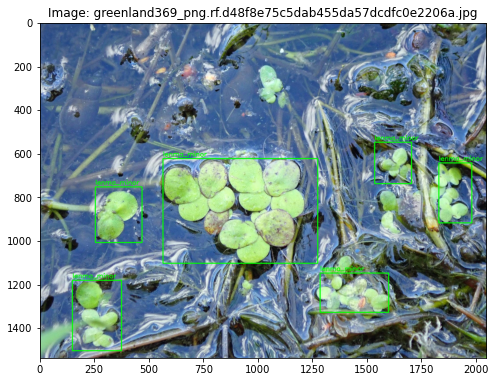

In [ ]:
# Show image with its bounding boxes from annotations in XML format (VOC)
def show_image_xml_label(dataset, index, category = None):
  image = cv2.imread(dataset.at[index,"image"])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  xml = open(dataset.at[index,"label"])
  tree = ElementTree.parse(xml)
  root = tree.getroot()
  
  for obj in root.iter('object'):
    label = obj.find('name').text

    xmlbox = obj.find('bndbox')
    xmin = int(float(xmlbox.find('xmin').text))
    xmax = int(float(xmlbox.find('xmax').text))
    ymin = int(float(xmlbox.find('ymin').text))
    ymax = int(float(xmlbox.find('ymax').text))
    
#     print(xmin, xmax, ymin, ymax)
    
    font = cv2.FONT_HERSHEY_SIMPLEX

    if category != None:
      if label == category: 
        # Put text
        cv2.putText(image, label,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)
        # Draw bounding box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0,255,0), 3)
    else: 
      # Put text
      cv2.putText(image, label,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)
      # Draw bounding box
      cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0,255,0), 3)

  plt.rcParams["figure.figsize"] = (8,8) 
  plt.imshow(image)
  plt.title('Image: '+dataset.at[index,"image"].split("/")[3])


num = random.randint(0, len(dataset)-1)  
# num = 2156
print(num)
show_image_xml_label(dataset, num)   

## Rename the images and create new version of the dataset

In [ ]:
new_dataset = dataset.copy()

NEW_DATASET_PATH = "version1"

if not os.path.exists(NEW_DATASET_PATH):
    os.mkdir(NEW_DATASET_PATH)

for idx, sample in tqdm(new_dataset.iterrows(), total=len(new_dataset)):
    new_img_filename = os.path.join(NEW_DATASET_PATH, str(idx) + ".jpg")
    new_xml_filename = os.path.join(NEW_DATASET_PATH, str(idx) + ".xml")
    
    shutil.copy(sample["image"], new_img_filename)
    shutil.copy(sample["label"], new_xml_filename)
    
    new_dataset.at[idx, "image"] = str(idx) + ".jpg"
    new_dataset.at[idx, "label"] = str(idx) + ".xml"
    
new_dataset

  0%|          | 0/3335 [00:00<?, ?it/s]

,labeller,image,label,instances
0,mauricio,0.jpg,0.xml,4
1,mauricio,1.jpg,1.xml,1
2,mauricio,2.jpg,2.xml,6
3,mauricio,3.jpg,3.xml,14
4,mauricio,4.jpg,4.xml,1
...,...,...,...,...
3330,yamil,3330.jpg,3330.xml,14
3331,yamil,3331.jpg,3331.xml,10
3332,yamil,3332.jpg,3332.xml,14
3333,yamil,3333.jpg,3333.xml,1


## Convert xml annotations to txt format

In [ ]:
# Function to get the image annotations from XML Annotation (PASCAL VOC format)
# and convert it to a dict
def extract_info_from_xml(xml_file):
  root = ElementTree.parse(xml_file).getroot()
  
  # Initialise the info dict 
  info_dict = {}
  info_dict['bboxes'] = []

  # Parse the XML Tree
  for elem in root:
    # Get the file name 
    if elem.tag == "filename":
      info_dict['filename'] = elem.text
        
    # Get the image size
    elif elem.tag == "size":
      image_size = {}
      for subelem in elem:
        
        image_size[subelem.tag] = int(subelem.text)
      
      info_dict['image_size'] = image_size
    
    # Get details of the bounding box 
    elif elem.tag == "object":
      bbox = {}
      for subelem in elem:
        if subelem.tag == "name":
          bbox["name"] = subelem.text
            
        elif subelem.tag == "bndbox":
          for subsubelem in subelem:
              bbox[subsubelem.tag] = int(float(subsubelem.text))            
      info_dict['bboxes'].append(bbox)
  
  return info_dict

# Function to convert the info dict to the required yolo v5 format and write it to disk
def convert_to_txt(info_dict, classes):
    print_buffer = []
    
    # For each bounding box
    for box in info_dict["bboxes"]:
      try:
        class_id = classes[box["name"]]

        # Normalise the co-ordinates by the dimensions of the image
        image_w = info_dict["image_size"]["width"]
        image_h = info_dict["image_size"]["height"]

        # print("image_w,image_h",image_w,image_h)
        dw = 1./image_w
        dh = 1./image_h
        # print("dw,dh:",dw,dh)
        # print("input: ",class_id, box["xmin"], box["ymin"], box["xmax"], box["ymax"])

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (box["xmin"] + box["xmax"]) / 2.0 
        b_center_y = (box["ymin"] + box["ymax"]) / 2.0 
        b_width    = (box["xmax"] - box["xmin"])
        b_height   = (box["ymax"] - box["ymin"])

        # print("transformed:",class_id, b_center_x, b_center_y, b_width, b_height)

        b_center_x = b_center_x*dw 
        b_center_y = b_center_y*dh
        b_width    = b_width*dw 
        b_height   = b_height*dh 

        # print("normalised:",class_id, b_center_x, b_center_y, b_width, b_height)

        # print()
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
      except KeyError:
        print("Invalid Class. Must be one from ", classes.keys()) 
    
    return print_buffer
  
# Convert the annotations to txt and generate new version of the dataset
def convert_xml_dataset_to_txt(dataset, previous_path, path, classes): 
  root = Path(path)
  new_dataset = pd.DataFrame(columns=['image','txt','label'])
  if not os.path.exists(path):
    os.makedirs(path)
  if not os.path.exists(path+"/labels"):
    os.makedirs(path+"/labels")
  if not os.path.exists(path+"/images"):
    os.makedirs(path+"/images")

  for idx, sample in tqdm(dataset.iterrows(), total=len(dataset)):
    info_dict = extract_info_from_xml(os.path.join(previous_path,sample["label"]))

    # Name of the file which we have to save
    file_name = sample["image"].replace("jpg","txt")
    save_file_name = root/"labels"/file_name
    print_buffer = convert_to_txt(info_dict, classes)
    if len(print_buffer)>0:
      print("\n".join(print_buffer), file= open(save_file_name, "w"))
    else:
      print("", file= open(save_file_name, "w"))

    # Move image files 
    source_image = os.path.join(previous_path, sample["image"])
    target_image = str(root/"images")
    shutil.copy(source_image, target_image)

    # Move xml files 
    source_xml = os.path.join(previous_path, sample["label"])
    target_xml = str(root/"labels")
    shutil.copy(source_xml, target_xml)

    # Append new row to pandas dataframe 
    new_dataset.loc[idx] = {'image':target_image.replace(path,"")+"/"+str(file_name).replace("txt","jpg"), 
                            'txt':str(save_file_name).replace(path,""), 
                            'label':target_xml.replace(path,"")+"/"+str(file_name).replace("txt","xml")}

  return new_dataset

FINAL_DATASET_PATH = "final_dataset/"

if os.path.exists(FINAL_DATASET_PATH):
  shutil.rmtree(FINAL_DATASET_PATH)
os.mkdir(FINAL_DATASET_PATH)
  
final_dataset = convert_xml_dataset_to_txt(new_dataset, "version1", FINAL_DATASET_PATH, {"lenma_minor":0,})
final_dataset["instances"] = new_dataset["instances"]
final_dataset.to_csv(FINAL_DATASET_PATH+"info.csv")

# Create Zip file with the dataset
shutil.make_archive("duckweed_dataset", 'zip', FINAL_DATASET_PATH)
print("Done!")

  0%|          | 0/3335 [00:00<?, ?it/s]

Done!


In [ ]:
final_dataset

,image,txt,label,instances
0,images/0.jpg,labels/0.txt,labels/0.xml,4
1,images/1.jpg,labels/1.txt,labels/1.xml,1
2,images/2.jpg,labels/2.txt,labels/2.xml,6
3,images/3.jpg,labels/3.txt,labels/3.xml,14
4,images/4.jpg,labels/4.txt,labels/4.xml,1
...,...,...,...,...
3330,images/3330.jpg,labels/3330.txt,labels/3330.xml,14
3331,images/3331.jpg,labels/3331.txt,labels/3331.xml,10
3332,images/3332.jpg,labels/3332.txt,labels/3332.xml,14
3333,images/3333.jpg,labels/3333.txt,labels/3333.xml,1


## Data Exploration

  0%|          | 0/3335 [00:00<?, ?it/s]

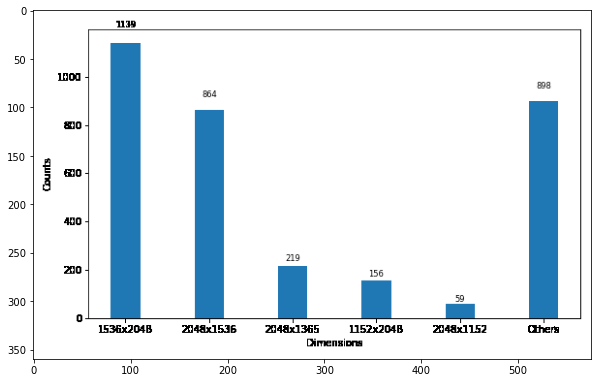

In [ ]:
# This function creates vertical plot visualizations
def create_visualization(image_sizes, new_plot_name):
  labels = list(image_sizes.keys())
  image_counts = list(image_sizes.values())

  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots(figsize=(8,5))
  rects = ax.bar(x, image_counts, width, label='Images')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Counts')
  ax.set_xlabel('Dimensions')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)

  for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.05*height,
            '%d' % int(height),ha='center', va='bottom', fontsize='small')

  fig.tight_layout()
  
  plt.savefig("plots/"+new_plot_name)
  plt.close(fig)
  # plt.show()
  
  return "plots/"+new_plot_name


# Find the image dimension distribution for datasets with regular aspect ratio
def find_dimension_distribution(path, dataset):
    if not os.path.exists('./plots'):
        os.makedirs('plots')
    image_sizes = {}

    for idx, sample in tqdm(dataset.iterrows(), total=len(dataset)):
        image = Image.open(os.path.join(path, sample["image"]))
        size = str(image.size[0]) +"x"+ str(image.size[1])
        if size not in image_sizes.keys():
            image_sizes[size] = 1
        else: 
            image_sizes[size] += 1

    return image_sizes
  
# Find the image dimension distribution for datasets with variable aspect ratio
def inconsistent_dataset(path, dataset):
    if not os.path.exists('./plots'):
        os.makedirs('plots')
    image_sizes = find_dimension_distribution(path, dataset)

    ordered_sizes = dict(sorted(image_sizes.items(), key=operator.itemgetter(1),reverse=True))

    aux = 0
    new_dict = {}
    count = 0
    for item in ordered_sizes.items():
        if aux<5:
            new_dict.update({item[0]:item[1]})
            aux+=1
        else: 
            count += item[1]

    new_dict.update({'Others':count})
    return new_dict

image_sizes = inconsistent_dataset("version1", new_dataset)

plot = create_visualization(image_sizes, "duckweed_dataset_sizes.png")

visualization = cv2.cvtColor(cv2.imread(plot), cv2.COLOR_BGR2RGB)

plt.rcParams["figure.figsize"] = (10,10) 
plt.imshow(visualization);

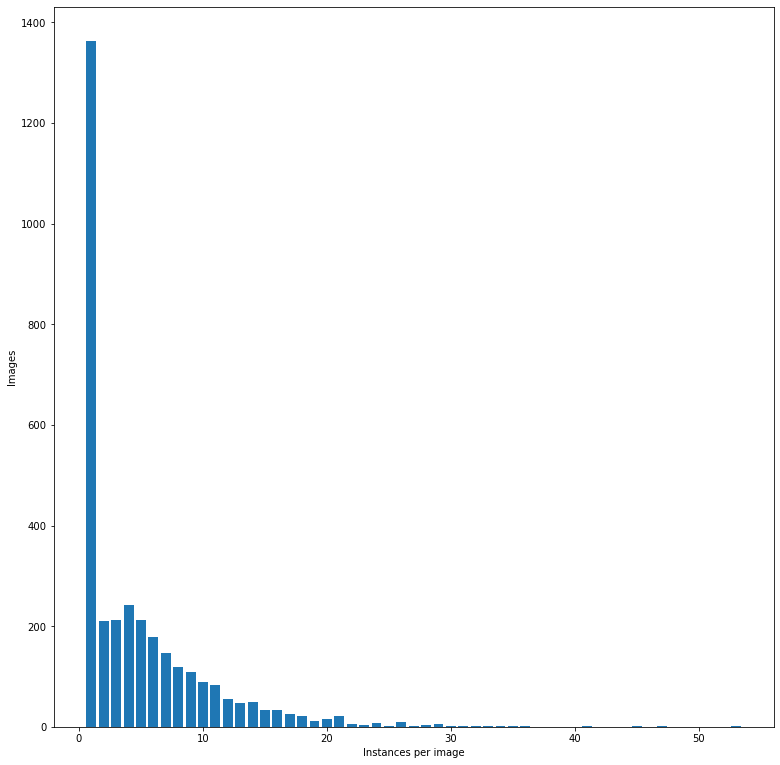

In [ ]:
def instance_distribution(instances_per_image):
  counts = {}
  
  for instances in instances_per_image:
    if instances in counts.keys():
      counts[instances] += 1
    else:
      counts[instances] = 1
    
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(counts.keys(),counts.values())
  ax.set_xlabel("Instances per image")
  ax.set_ylabel("Images")
  plt.show()

instance_distribution(with_objects)  